# CellDART Example Code: mouse brain 
## (10x Visium of anterior mouse brain + scRNA-seq data of mouse brain)

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from CellDART import da_cellfraction
from CellDART.utils import random_mix
from math import ceil
from sklearn.manifold import TSNE
import glob
import os
import anndata as ad
import sklearn
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

## 1. Data load
### load scanpy data - 10x datasets

In [2]:
spatialLIBD_dir = '../AGrEDA/data/spatialLIBD'

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

adata_dir = os.path.join(spatialLIBD_dir, 'adata')

adata_spatialLIBD_d = {}

for name in glob.glob(os.path.join(adata_dir, 'adata_spatialLIBD-*.h5ad')):
    sample_id = int(name.partition("-")[2].rpartition(".")[0])
    # print(sample_id)
    adata_spatialLIBD_d[sample_id] = sc.read_h5ad(name)

-----
anndata     0.8.0
scanpy      1.9.1
-----
CellDART                                    NA
PIL                                         9.2.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
asttokens                                   NA
astunparse                                  1.6.3
backcall                                    0.2.0
beta_ufunc                                  NA
binom_ufunc                                 NA
certifi                                     2022.09.24
cffi                                        1.15.1
charset_normalizer                          2.1.1
cycler                                      0.10.0
cython_runtime                              NA
dateutil                                    2.8.2
debugpy                                     1.6.3
decorator                                   5.1.1
defusedxml                                  0.7.1
dill                                        0.3.5.1
entrypoints   

### Single cell Data: GSE115746 
 - Download from GEO and use two files "GSE115746_cells_exon_counts.csv" and "GSE115746_complete_metadata_28706-cells.csv"

In [3]:
adata_sc_dlpfc = sc.read_h5ad('../AGrEDA/data/sc_dlpfc/adata_sc_dlpfc.h5ad')
sc.pp.normalize_total(adata_sc_dlpfc, inplace=True, target_sum=1e6)
adata_sc_dlpfc.var_names_make_unique()


normalizing counts per cell
    finished (0:00:00)


In [4]:
# #Preprocessing
# adata_sc_dlpfc.var['mt'] = adata_sc_dlpfc.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata_sc_dlpfc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# sc.pp.normalize_total(adata_sc_dlpfc)

# #PCA and clustering : Known markers with 'cell_subclass'
# sc.tl.pca(adata_sc_dlpfc, svd_solver='arpack')
# sc.pp.neighbors(adata_sc_dlpfc, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_sc_dlpfc)
# sc.tl.leiden(adata_sc_dlpfc, resolution = 0.5)
# sc.pl.umap(adata_sc_dlpfc, color=['leiden','cell_subclass'])


In [5]:
# sc.tl.rank_genes_groups(adata_sc_dlpfc, 'cell_subclass', method='wilcoxon')
# # sc.pl.rank_genes_groups(adata_sc_dlpfc, n_genes=20, sharey=False)
# genelists = adata_sc_dlpfc.uns['rank_genes_groups']['names']
# df_genelists = pd.DataFrame.from_records(genelists)
# df_genelists.to_pickle('data/sc_dlpfc/df_genelists.pkl')

In [6]:
num_markers=20
df_genelists = pd.read_pickle('../AGrEDA/data/sc_dlpfc/df_genelists.pkl')
res_genes = []
for column in df_genelists.head(num_markers):
    res_genes.extend(df_genelists.head(num_markers)[column].tolist())
res_genes_ = list(set(res_genes))

### Select same gene features 

In [7]:
adata_spatialLIBD = ad.concat(adata_spatialLIBD_d.values(), label='sample_id', keys = adata_spatialLIBD_d.keys())
adata_spatialLIBD.obs_names_make_unique()
sc.pp.normalize_total(adata_spatialLIBD, inplace=True, target_sum=1e6)

normalizing counts per cell


/projects/wma/.conda2/envs/CellDART/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)


In [8]:
adata_spatialLIBD.var_names_make_unique() 
inter_genes = [val for val in res_genes_ if val in adata_spatialLIBD.var.index]
print('Selected Feature Gene number',len(inter_genes))
adata_sc_dlpfc = adata_sc_dlpfc[:,inter_genes]

adata_spatialLIBD = adata_spatialLIBD[:,inter_genes]


Selected Feature Gene number 362


In [9]:
adata_spatialLIBD.obs['sample_id'].unique()


[151509, 151510, 151671, 151508, 151670, ..., 151676, 151675, 151673, 151672, 151669]
Length: 12
Categories (12, int64): [151509, 151510, 151671, 151508, ..., 151675, 151673, 151672, 151669]

### Array of single cell & spatial data
- Single cell data with labels
- Spatial data without labels


In [10]:
mat_sc = adata_sc_dlpfc.X.todense()
# mat_sp_train = adata_spatialLIBD[adata_spatialLIBD.obs.sample_id == 151673].X.todense()
mat_sp_train = adata_spatialLIBD.X.todense()
mat_sp_test = adata_spatialLIBD[adata_spatialLIBD.obs.sample_id == 151673].X.todense()

df_sc = adata_sc_dlpfc.obs

lab_sc_sub = df_sc.cell_subclass
sc_sub_dict = dict(zip(range(len(set(lab_sc_sub))), df_genelists.columns.tolist()))
sc_sub_dict2 = dict((y,x) for x,y in sc_sub_dict.items())
lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
lab_sc_num = np.asarray(lab_sc_num, dtype='int')

## 2. Generate mixture from single cell data and preprocessing

In [11]:
from sklearn.model_selection import train_test_split

mat_sc_train, mat_sc_test, lab_sc_num_train, lab_sc_num_test = train_test_split(
    mat_sc, lab_sc_num, test_size=0.2, random_state=225,stratify = lab_sc_num
)


sc_mix_train, lab_mix_train = random_mix(mat_sc_train, lab_sc_num_train, nmix=8, n_samples=20000)
sc_mix_test, lab_mix_test = random_mix(mat_sc_test, lab_sc_num_test, nmix=8, n_samples=5000)

def log_minmaxscale(arr):
    arrd = len(arr)
    arr = np.log1p(arr)
    return (arr-np.reshape(np.min(arr,axis=1), (arrd,1)))/np.reshape((np.max(arr, axis=1)-np.min(arr,axis=1)),(arrd,1))

sc_mix_train_s = log_minmaxscale(sc_mix_train)
sc_mix_test_s = log_minmaxscale(sc_mix_test)

mat_sp_train_s = log_minmaxscale(mat_sp_train)
mat_sp_test_s = log_minmaxscale(mat_sp_test)
mat_sc_s = log_minmaxscale(mat_sc)


In [12]:
print(mat_sp_train_s.shape, mat_sp_test_s.shape, mat_sc_s.shape, sc_mix_train_s.shape, sc_mix_test_s.shape)

(47681, 362) (3639, 362) (35212, 362) (20000, 362) (5000, 362)


## 3. Training: Adversarial domain adaptation for cell fraction estimation
### Parameters
- alpha: loss weights for adversarial learning for pooling domain classifier
- alpha_lr: learning rate for training domain classifier  (alpha_lr *0.001)
- emb_dim: embedding dimension (feature dimension)
- batch_size : batch size for the training
- n_iterations: iteration number of adversarial training
- initial_train: if true, classifier model is trained firstly before adversarial domain adaptation
- initial_train_epochs: number of epochs for inital training



In [13]:
embs, clssmodel = da_cellfraction.train(sc_mix_train_s, lab_mix_train, mat_sp_train_s, 
                                        alpha=0.6, alpha_lr=5, emb_dim = 64, batch_size = 512,
                                        n_iterations = 3000,
                                        initial_train=True,
                                        initial_train_epochs=100)

Train on 20000 samples
Epoch 1/100
20000/20000 [==============================] - 1s 49us/sample - loss: 1.2465 - mae: 0.0354
Epoch 2/100
20000/20000 [==============================] - 1s 35us/sample - loss: 0.8553 - mae: 0.0287
Epoch 3/100
20000/20000 [==============================] - 1s 34us/sample - loss: 0.6917 - mae: 0.0254
Epoch 4/100
20000/20000 [==============================] - 1s 34us/sample - loss: 0.6114 - mae: 0.0233
Epoch 5/100
20000/20000 [==============================] - 1s 34us/sample - loss: 0.5759 - mae: 0.0222
Epoch 6/100
20000/20000 [==============================] - 1s 34us/sample - loss: 0.5536 - mae: 0.0216
Epoch 7/100
20000/20000 [==============================] - 1s 34us/sample - loss: 0.5357 - mae: 0.0212
Epoch 8/100
20000/20000 [==============================] - 1s 34us/sample - loss: 0.5218 - mae: 0.0208
Epoch 9/100
20000/20000 [==============================] - 1s 34us/sample - loss: 0.5092 - mae: 0.0204
Epoch 10/100
20000/20000 [========================

/projects/wma/.conda2/envs/CellDART/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Iteration 99, source loss =  2.570, discriminator acc = 0.366
Iteration 199, source loss =  5.031, discriminator acc = 0.704
Iteration 299, source loss =  3.926, discriminator acc = 0.338
Iteration 399, source loss =  1.762, discriminator acc = 0.401
Iteration 499, source loss =  1.698, discriminator acc = 0.704
Iteration 599, source loss =  1.656, discriminator acc = 0.704
Iteration 699, source loss =  1.520, discriminator acc = 0.210
Iteration 799, source loss =  1.960, discriminator acc = 0.703
Iteration 899, source loss =  1.464, discriminator acc = 0.679
Iteration 999, source loss =  1.465, discriminator acc = 0.897
Iteration 1099, source loss =  1.207, discriminator acc = 0.704
Iteration 1199, source loss =  1.273, discriminator acc = 0.700
Iteration 1299, source loss =  1.445, discriminator acc = 0.717
Iteration 1399, source loss =  1.202, discriminator acc = 0.704
Iteration 1499, source loss =  1.564, discriminator acc = 0.705
Iteration 1599, source loss =  1.822, discriminator

## 4. Predict cell fraction of spots and visualization

In [14]:
pred_sp = clssmodel.predict(mat_sp_test_s)
adata_spatialLIBD_151673 =  adata_spatialLIBD[adata_spatialLIBD.obs.sample_id == 151673]

adata_spatialLIBD_151673.obsm['spatial'] = adata_spatialLIBD_151673.obs[['X','Y']].values


/projects/wma/.conda2/envs/CellDART/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [15]:
num_name_exN_l = []
for k, v in sc_sub_dict.items():
    if 'Ex' in v:
        num_name_exN_l.append((k, v, int(v.split('_')[1])))
num_name_exN_l.sort(key=lambda a: a[2])
num_name_exN_l

[(4, 'Ex_1_L5_6', 1),
 (5, 'Ex_2_L5', 2),
 (6, 'Ex_3_L4_5', 3),
 (7, 'Ex_4_L_6', 4),
 (8, 'Ex_5_L5', 5),
 (9, 'Ex_6_L4_6', 6),
 (10, 'Ex_7_L4_6', 7),
 (11, 'Ex_8_L5_6', 8),
 (12, 'Ex_9_L5_6', 9),
 (13, 'Ex_10_L2_4', 10)]

In [16]:
Ex_to_L_d = {
    1 : {5,6},
    2 : {5},
    3 : {4,5},
    4 : {6},
    5 : {5},
    6 : {4,5,6},
    7 : {4,5,6},
    8 : {5,6},
    9 : {5,6},
    10: {2,3,4}
}

In [17]:
numlist = [t[0] for t in num_name_exN_l]
Ex_l = [t[2] for t in num_name_exN_l]
num_to_ex_d = dict(zip(numlist, Ex_l))


In [18]:

def plot_cellfraction(visnum, ax=None):
    adata_spatialLIBD_151673.obs['Pred_label'] = pred_sp[:,visnum]
    vmin = 0
    vmax = np.amax(pred_sp)
    

    sc.pl.spatial(
        adata_spatialLIBD_151673,
        img_key="hires",
        color='Pred_label',
        palette='Set1',
        size=1.5,
        legend_loc=None,
        title = f'{sc_sub_dict[visnum]} 151673',
        spot_size=100,
        show=False,
        # vmin=vmin,
        # vmax=vmax,
        ax=ax)

In [19]:
def plot_cell_layers(df):
    
    layer_idx = df["spatialLIBD"].unique().astype(str)
    samples = df["sample_id"].unique()
    layer_idx.sort()
    fig, ax = plt.subplots(nrows = 1, ncols = len(samples), figsize = (5*len(samples),5), squeeze=False, constrained_layout=True)


    
    for idx, sample in enumerate(samples):
        cells_of_samples = df[df["sample_id"] == sample]
        for index in layer_idx:
            cells_of_layer = cells_of_samples[cells_of_samples["spatialLIBD"] == index]
            ax.flat[idx].scatter(cells_of_layer["X"], -cells_of_layer["Y"], label = index, s=17, marker='o')
        
        ax.flat[idx].axis('equal')
        ax.flat[idx].set_xticks([])
        ax.flat[idx].set_yticks([])
        ax.flat[idx].set_title(sample)
        
    plt.legend()
    plt.show()



In [20]:
from sklearn.metrics import RocCurveDisplay




def plot_roc(visnum, ax=None):
    def layer_to_layer_number(x):
        for char in x:
            if char.isdigit():
                if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
                    return 1
        return 0
    y_pred =  pred_sp[:,visnum]
    y_true = adata_spatialLIBD_151673.obs['spatialLIBD'].map(layer_to_layer_number).fillna(0)
    # print(y_true)
    # print(y_true.isna().sum())
    RocCurveDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        name = 'CellDART',
        ax = ax
    )
    


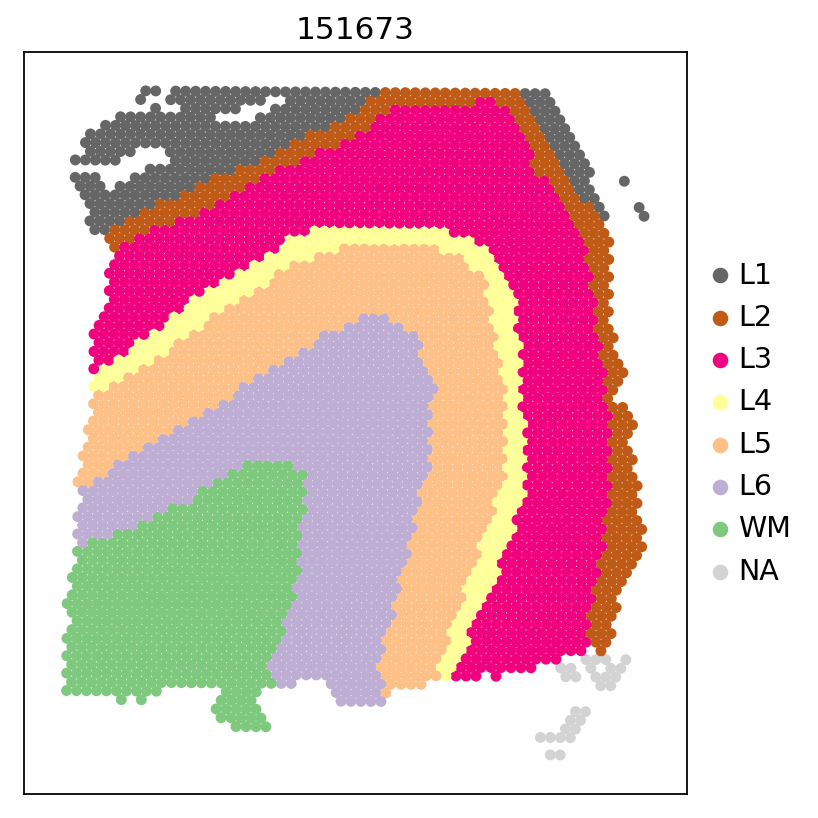

In [21]:
# plot_cell_layers(adata_spatialLIBD_151673.obs)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5),constrained_layout=True)

sc.pl.spatial(
    adata_spatialLIBD_151673,
    img_key=None,
    color="spatialLIBD",
    palette='Accent_r',
    size=1.5,
    title = f'151673',
    # legend_loc = 4,
    spot_size=100,
    show=False,
    ax=ax)

ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')

fig.show()

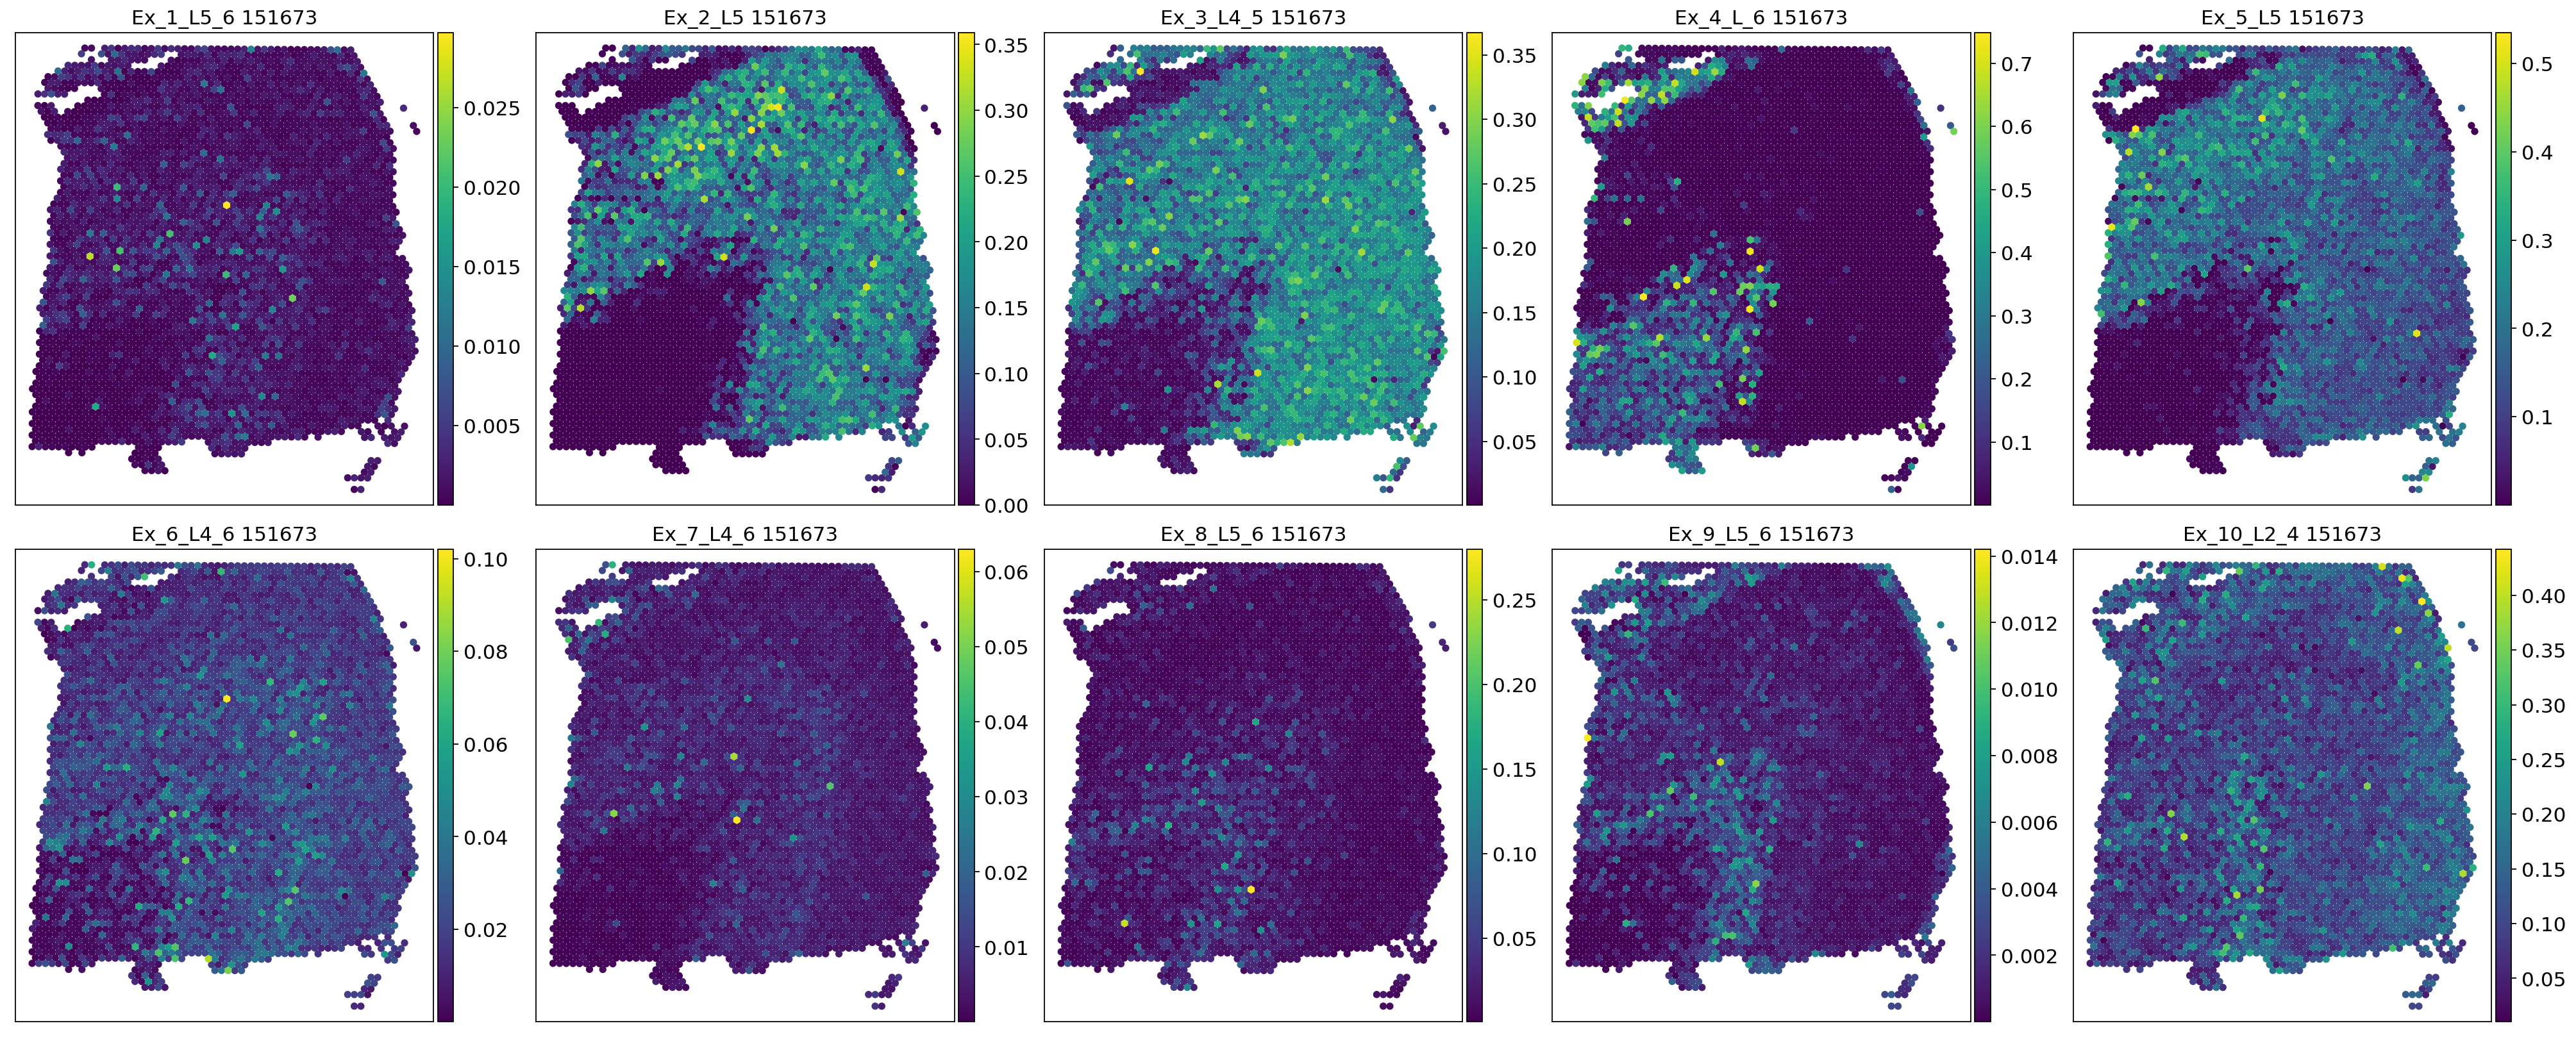

In [22]:

fig, ax = plt.subplots(2, 5, figsize=(25,10), constrained_layout=True)

for i, num in enumerate(numlist):
    plot_cellfraction(num, ax.flat[i])
    ax.flat[i].axis('equal')
    ax.flat[i].set_xlabel('')
    ax.flat[i].set_ylabel('')

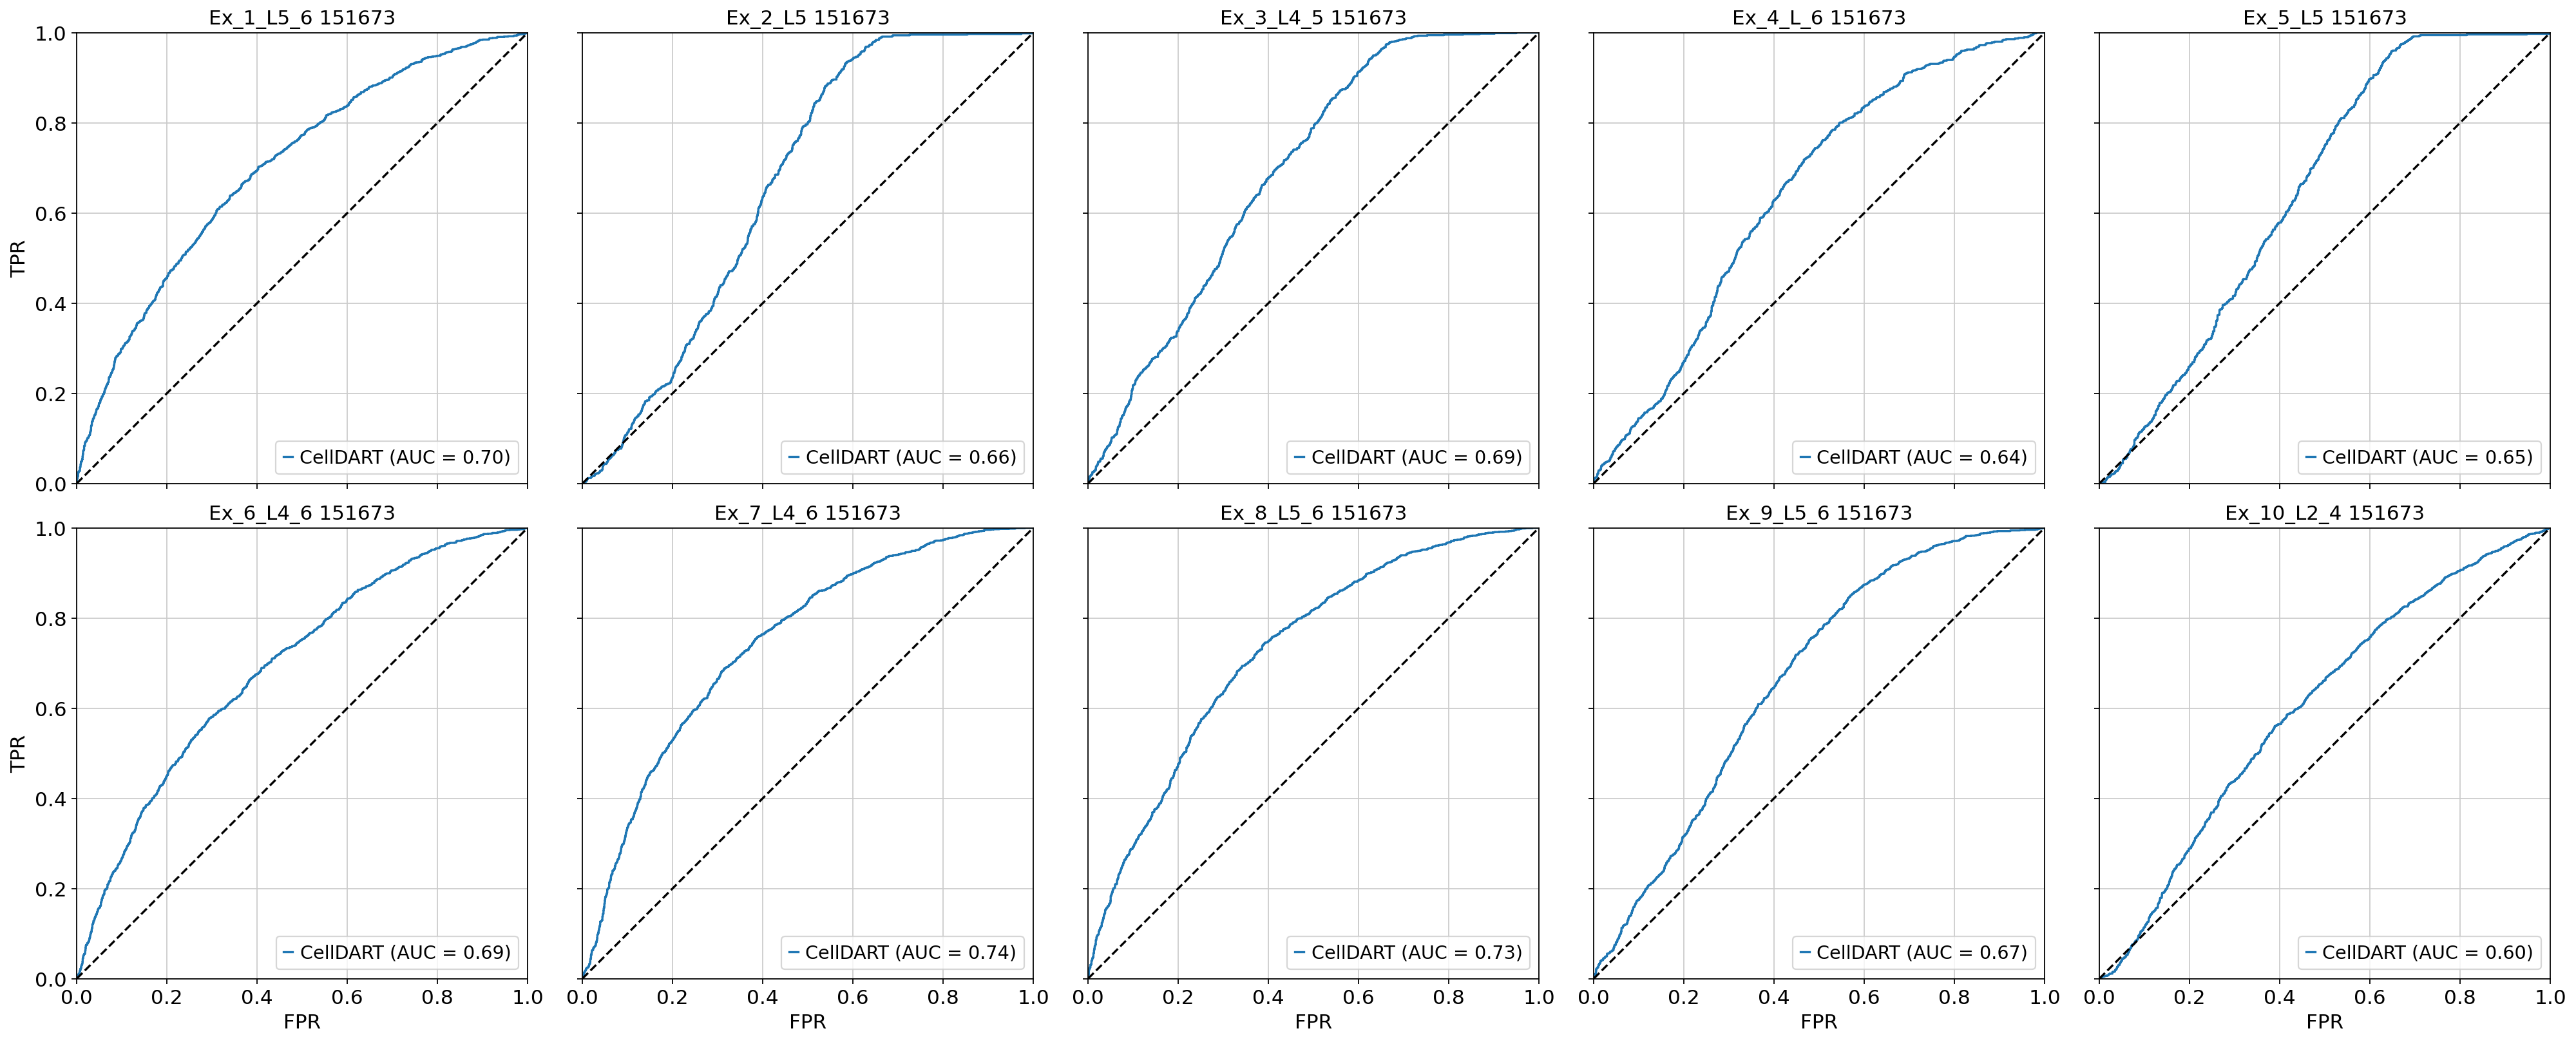

In [23]:

fig, ax = plt.subplots(2, 5, figsize=(25,10), constrained_layout=True, sharex=True, sharey=True)

for i, num in enumerate(numlist):
    plot_roc(num, ax.flat[i])
    ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls='--', color='k')
    ax.flat[i].set_aspect('equal')
    ax.flat[i].set_xlim([0,1])
    ax.flat[i].set_ylim([0,1])
    
    ax.flat[i].set_title(f'{sc_sub_dict[num]} 151673')

    if i >= len(numlist) - 5:
        ax.flat[i].set_xlabel('FPR')
    else:
        ax.flat[i].set_xlabel('')
    if  i % 5 == 0:
        ax.flat[i].set_ylabel('TPR')
    else:
        ax.flat[i].set_ylabel('')


- cf. Prediction of Mixture (pseudospots)


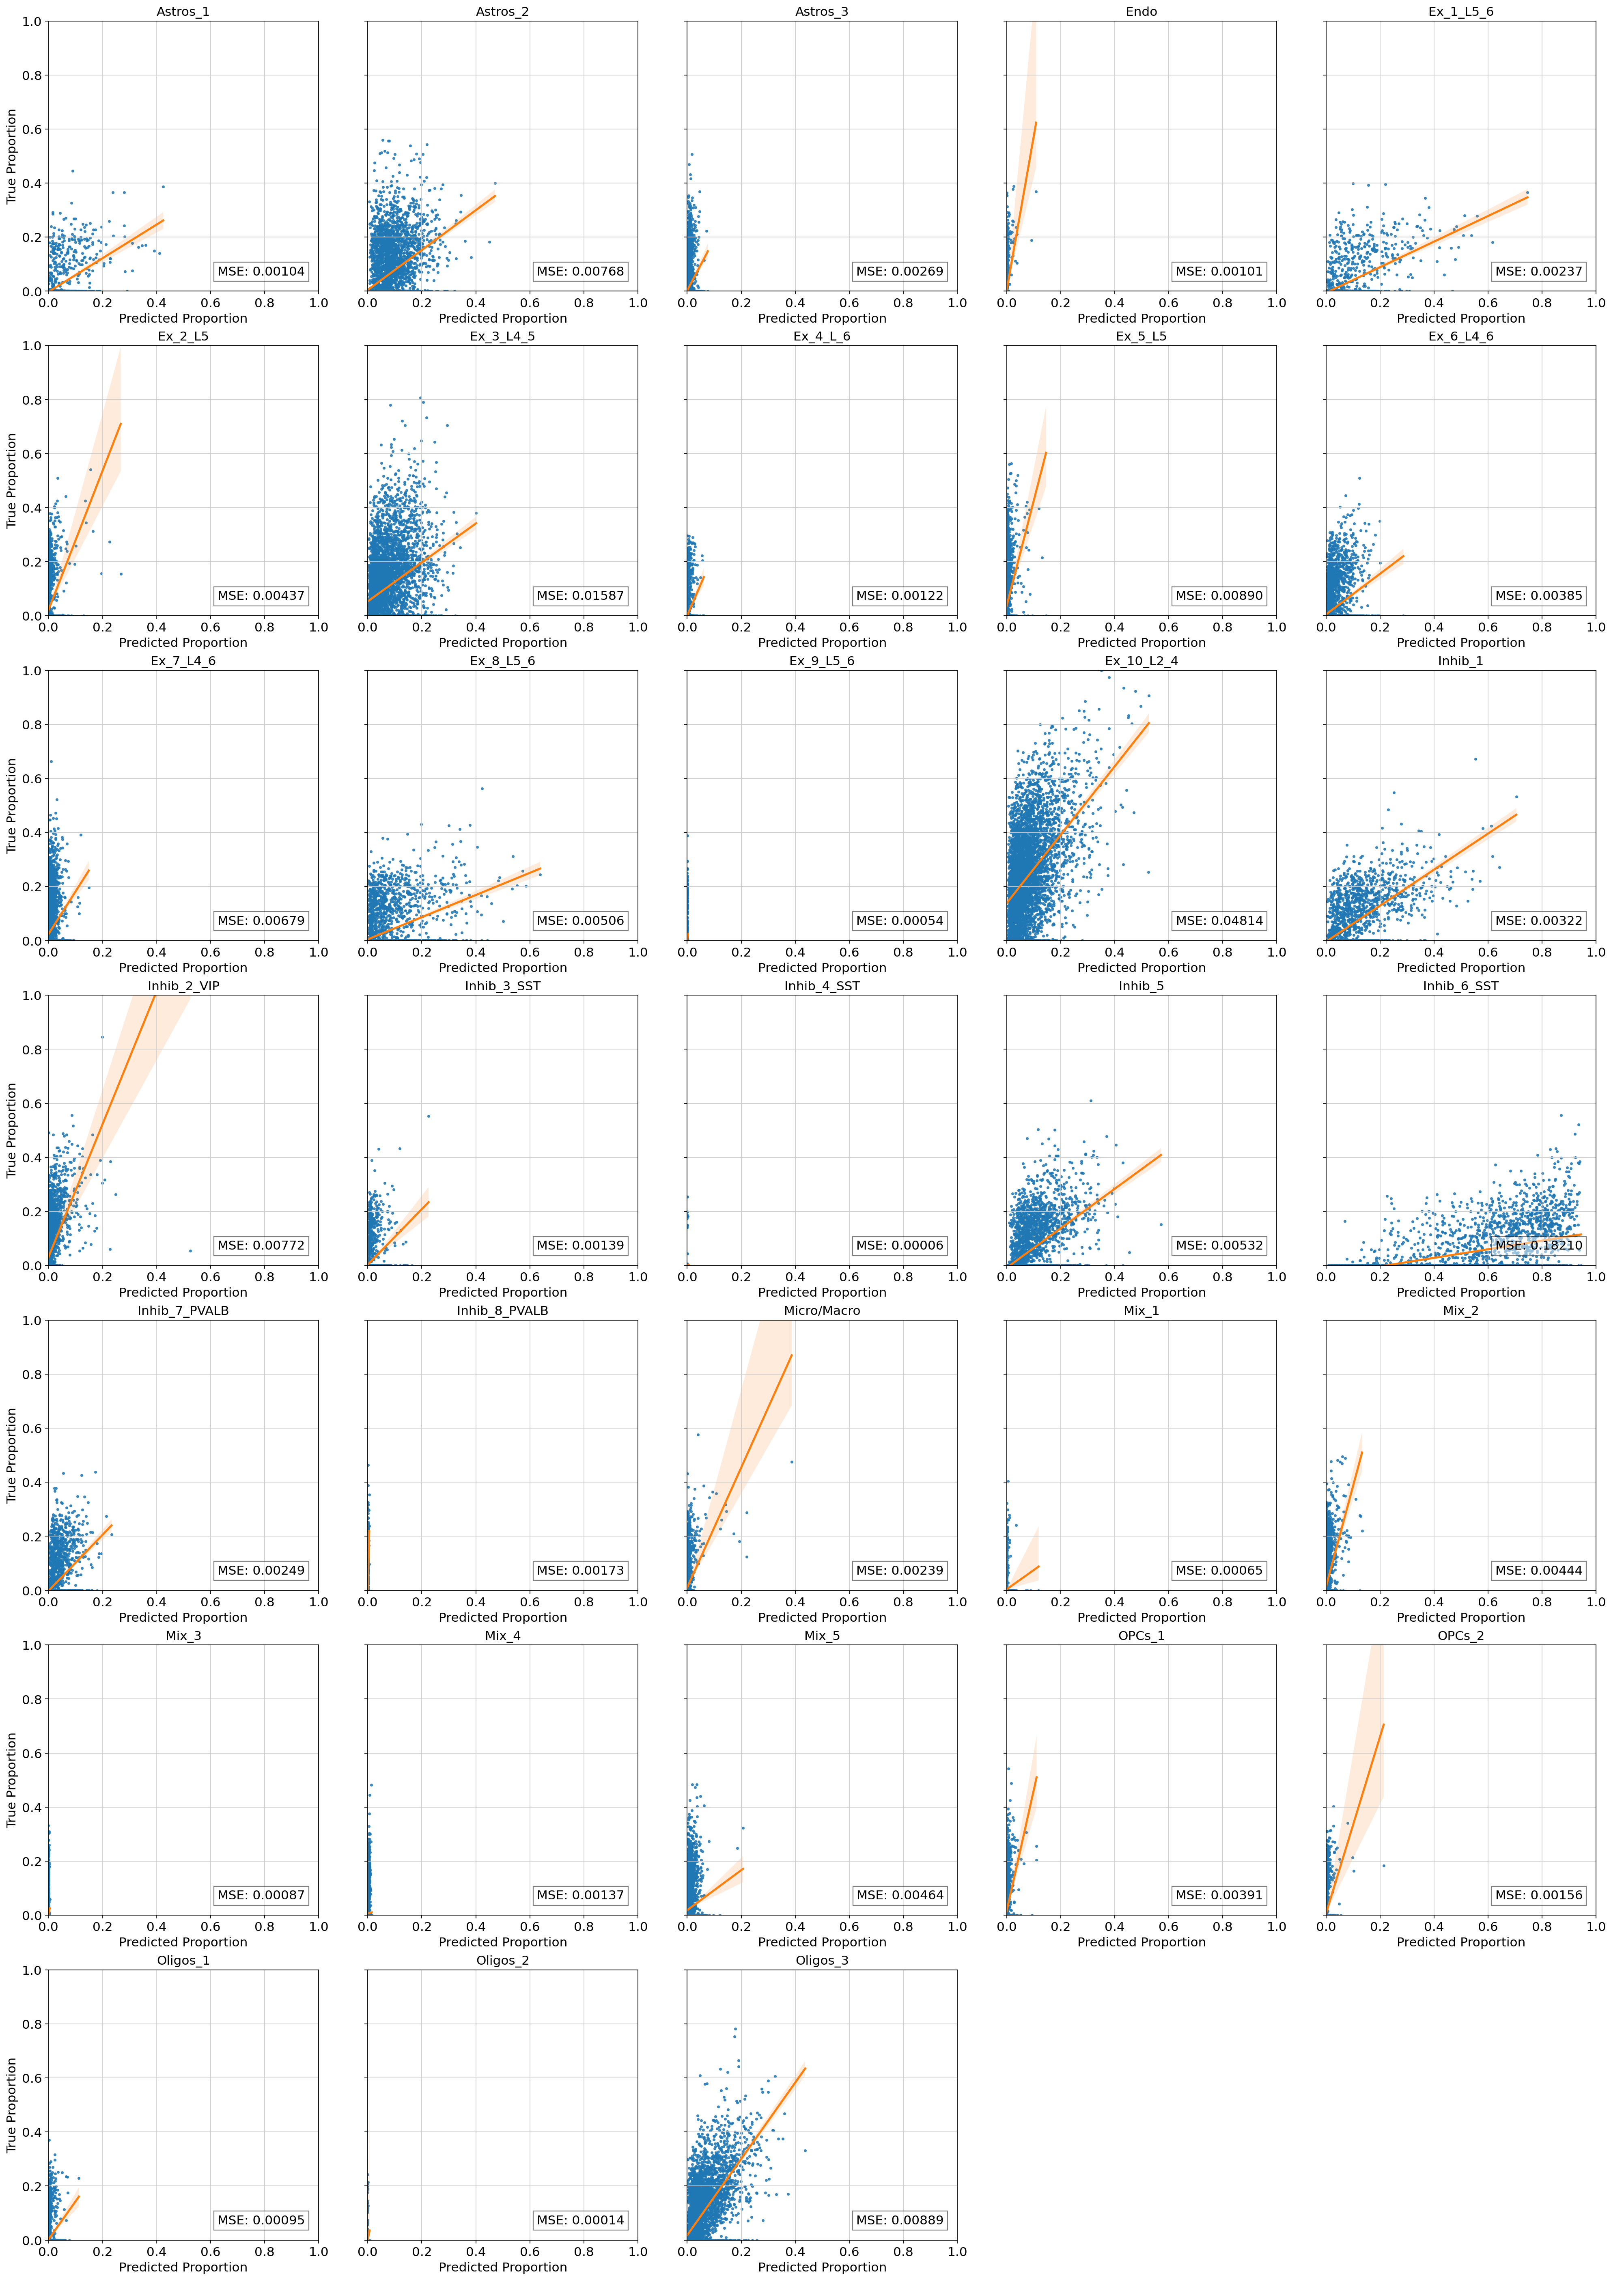

In [25]:
from sklearn.metrics import mean_squared_error

pred_mix = clssmodel.predict(sc_mix_test_s)


cell_type_nums = sc_sub_dict.keys()
nrows = ceil(len(cell_type_nums) / 5)

line_kws = {'color':'tab:orange'}
scatter_kws = {'s':5}

props = dict(facecolor='w', alpha=0.5)

fig, ax = plt.subplots(nrows, 5, figsize = (25, 5*nrows), constrained_layout=True, sharex=False, sharey=True)
for i, visnum in enumerate(cell_type_nums):    
    sns.regplot(
        x=pred_mix[:,visnum],
        y=lab_mix_test[:,visnum], 
        line_kws = line_kws,
        scatter_kws = scatter_kws,
        ax=ax.flat[i]
    ).set_title(sc_sub_dict[visnum])
    ax.flat[i].set_aspect('equal')

    # if i >= len(cell_type_nums) - 5:
    ax.flat[i].set_xlabel('Predicted Proportion')
    # else:
    #     ax.flat[i].set_xlabel('')
    if  i % 5 == 0:
        ax.flat[i].set_ylabel('True Proportion')
    else:
        ax.flat[i].set_ylabel('')
    ax.flat[i].set_xlim([0,1])
    ax.flat[i].set_ylim([0,1])

    textstr = f'MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}'

    # place a text box in upper left in axes coords
    ax.flat[i].text(0.95, 0.05, textstr, transform=ax.flat[i].transAxes,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

for i in range(len(cell_type_nums), nrows*5):
    ax.flat[i].axis('off')

plt.show()

In [26]:

print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

scanpy 1.9.1
pandas 1.4.4
numpy 1.20.3
seaborn 0.12.0
anndata 0.8.0
sklearn 1.1.2


In [27]:
import keras
keras.__version__

'2.9.0'

In [28]:
adata_spatialLIBD_151673.obs

X      Y                 index  \
spot                                                      
AAACAAGTATCTCCCA-1-9  9791   8468  AAACAAGTATCTCCCA-1.8   
AAACAATCTACTAGCA-1-5  5769   2807  AAACAATCTACTAGCA-1.3   
AAACACCAATAACTGC-1-9  4068   9505  AAACACCAATAACTGC-1.8   
AAACAGAGCGACTCCT-1-8  9271   4151  AAACAGAGCGACTCCT-1.7   
AAACAGCTTTCAGAAG-1-7  3393   7583  AAACAGCTTTCAGAAG-1.7   
...                    ...    ...                   ...   
TTGTTTCACATCCAGG-1-9  5653   9396  TTGTTTCACATCCAGG-1.8   
TTGTTTCATTAGTCTA-1-9  4825   9630  TTGTTTCATTAGTCTA-1.8   
TTGTTTCCATACAACT-1-9  4631   7831  TTGTTTCCATACAACT-1.8   
TTGTTTGTATTACACG-1-6  5571  11193  TTGTTTGTATTACACG-1.4   
TTGTTTGTGTAAATTC-1-8  6317   3291  TTGTTTGTGTAAATTC-1.8   

                                            key subject  replicate  Cluster  \
spot                                                                          
AAACAAGTATCTCCCA-1-9  151673_AAACAAGTATCTCCCA-1  Br8100          1        7   
AAACAATCTACTAGCA-1-5  151673_AAACAATCTACTAGCA-1  Br8100          1        4   
AAACACCAATAACTGC-1-9  151673_AAACACCAATAACTGC-1  Br8100          1        8   
AAACAGAGCGACTCCT-1-8  151673_AAACAGAGCGACTCCT-1  Br8100          1        6   
AAACAGCTTTCAGAAG-1-7  151673_AAACAGCTTTCAGAAG-1  Br8100          1        3   
...                                         ...     ...        ...      ...   
TTGTTTCACATCCAGG-1-9  151673_TTGTTTCACATCCAGG-1  Br8100          1        8   
TTGTTTCATTAGTCTA-1-9  151673_TTGTTTCATTAGTCTA-1  Br8100          1        8   
TTGTTTCCATACAACT-1-9  151673_TTGTTTCCATACAACT-1  Br8100          1        6   
TTGTTTGTATTACACG-1-6  151673_TTGTTTGTATTACACG-1  Br8100          1        6   
TTGTTTGTGTAAATTC-1-8  151673_TTGTTTGTGTAAATTC-1  Br8100          1        7   

                      sum_umi  sum_gene  cell_count  in_tissue spatialLIBD  \
spot                                                                         
AAACAAGTATCTCCCA-1-9     8458      3586           6       True          L3   
AAACAATCTACTAGCA-1-5     1667      1150          16       True          L1   
AAACACCAATAACTGC-1-9     3769      1960           5       True          WM   
AAACAGAGCGACTCCT-1-8     5433      2424           2       True          L3   
AAACAGCTTTCAGAAG-1-7     4278      2264           4       True          L5   
...                       ...       ...         ...        ...         ...   
TTGTTTCACATCCAGG-1-9     4324      2170           3       True          WM   
TTGTTTCATTAGTCTA-1-9     2761      1560           4       True          WM   
TTGTTTCCATACAACT-1-9     2322      1343           3       True          L6   
TTGTTTGTATTACACG-1-6     2331      1420          16       True          WM   
TTGTTTGTGTAAATTC-1-8     6281      2927           5       True          L2   

                      array_col  array_row sample_id  Pred_label  
spot                                                              
AAACAAGTATCTCCCA-1-9        102         50    151673    0.102226  
AAACAATCTACTAGCA-1-5         43          3    151673    0.078639  
AAACACCAATAACTGC-1-9         19         59    151673    0.169187  
AAACAGAGCGACTCCT-1-8         94         14    151673    0.211265  
AAACAGCTTTCAGAAG-1-7          9         43    151673    0.068326  
...                         ...        ...       ...         ...  
TTGTTTCACATCCAGG-1-9         42         58    151673    0.026356  
TTGTTTCATTAGTCTA-1-9         30         60    151673    0.112607  
TTGTTTCCATACAACT-1-9         27         45    151673    0.128701  
TTGTTTGTATTACACG-1-6         41         73    151673    0.070344  
TTGTTTGTGTAAATTC-1-8         51          7    151673    0.090713  

[3639 rows x 16 columns]

In [29]:
adata_spatialLIBD_151673.obs['spatialLIBD'].unique()

['L3', 'L1', 'WM', 'L5', 'L6', 'L2', 'L4', NaN]
Categories (7, object): ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'WM']